## <span style="color:#db7d60">Setup</span>

In [1]:
%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import pUtil
from analysis_common import *
import data_manager
import analysis as anal

import vector
from particle import Particle
from particle import PDGID

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

/global/homes/e/eshy/.local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## <span style="color:#db7d60">Analysis</span>

- Ensure energy conservation.
	- Vector sum of secondaries and compare to primary to ensure the 4vector adds up.
    - pt, eta, phi, mass is the 4vector.
	- Plot the added energy distribution (vector.energy) and see if they match.
	- Make sure to add the material in this calculation. (primary + material is incoming. The generated are just the secondaries.)


In [2]:
model_name = 'model_5_9_1'

# Filenames
dictionary_filename = pUtil.get_model_preparation_dir(model_name) / 'dictionary.json'
testing_bin_filename = pUtil.get_model_preparation_dir(model_name) / 'test_real.bin'
generated_samples_filename = pUtil.get_latest_sampling_dir(model_name) / 'untokenized_samples.csv'

# Load required information
dictionary = Dictionary(dictionary_filename)
meta_data = anal.tables.get_meta_data(model_name)

num_tokens_per_particle_raw = 5
num_particles_per_event = ((meta_data.max_sequence_length - 2) // len(dictionary.dictionary_data['tokenization']))

# Load datasets
testing_real_data = np.memmap(testing_bin_filename, dtype=np.float64, mode='r')
testing_real_data = testing_real_data.reshape(-1, num_particles_per_event, num_tokens_per_particle_raw)
generated_sample_data = data_manager.load_geant4_dataset(generated_samples_filename, pad_token=0.0)

# Perform computation
mass_carbon = 931.5 * 12 # MeV

computed_data = np.full(shape=(len(generated_sample_data), 2), fill_value=np.nan)
for idx, event in enumerate(generated_sample_data):
    # Input vector
    primary_particle = Particle.from_pdgid(event[0][0])
    in_particle_vec = vector.obj(mass=primary_particle.mass, px=event[0][2], py=event[0][3], pz=event[0][4])
    in_material_vec = vector.obj(mass=mass_carbon, px=0.0, py=0.0, pz=0.0)
    in_vec = in_particle_vec + in_material_vec
    
    # Output vector
    out_vec = vector.obj(mass=0.0, px=0.0, py=0.0, pz=0.0)
    for particle in event[1:]:
        if particle[0] == 0.0:
            continue
        i_particle = Particle.from_pdgid(particle[0])
        i_vec = vector.obj(mass=i_particle.mass, px=particle[2], py=particle[3], pz=particle[4])
        out_vec += i_vec
    
    computed_data[idx] = in_vec.e, out_vec.e

min: 0.0018111293829861097 max: 31682.03584477678 range: 31682.034033647396 mean: 2713.6855405830574


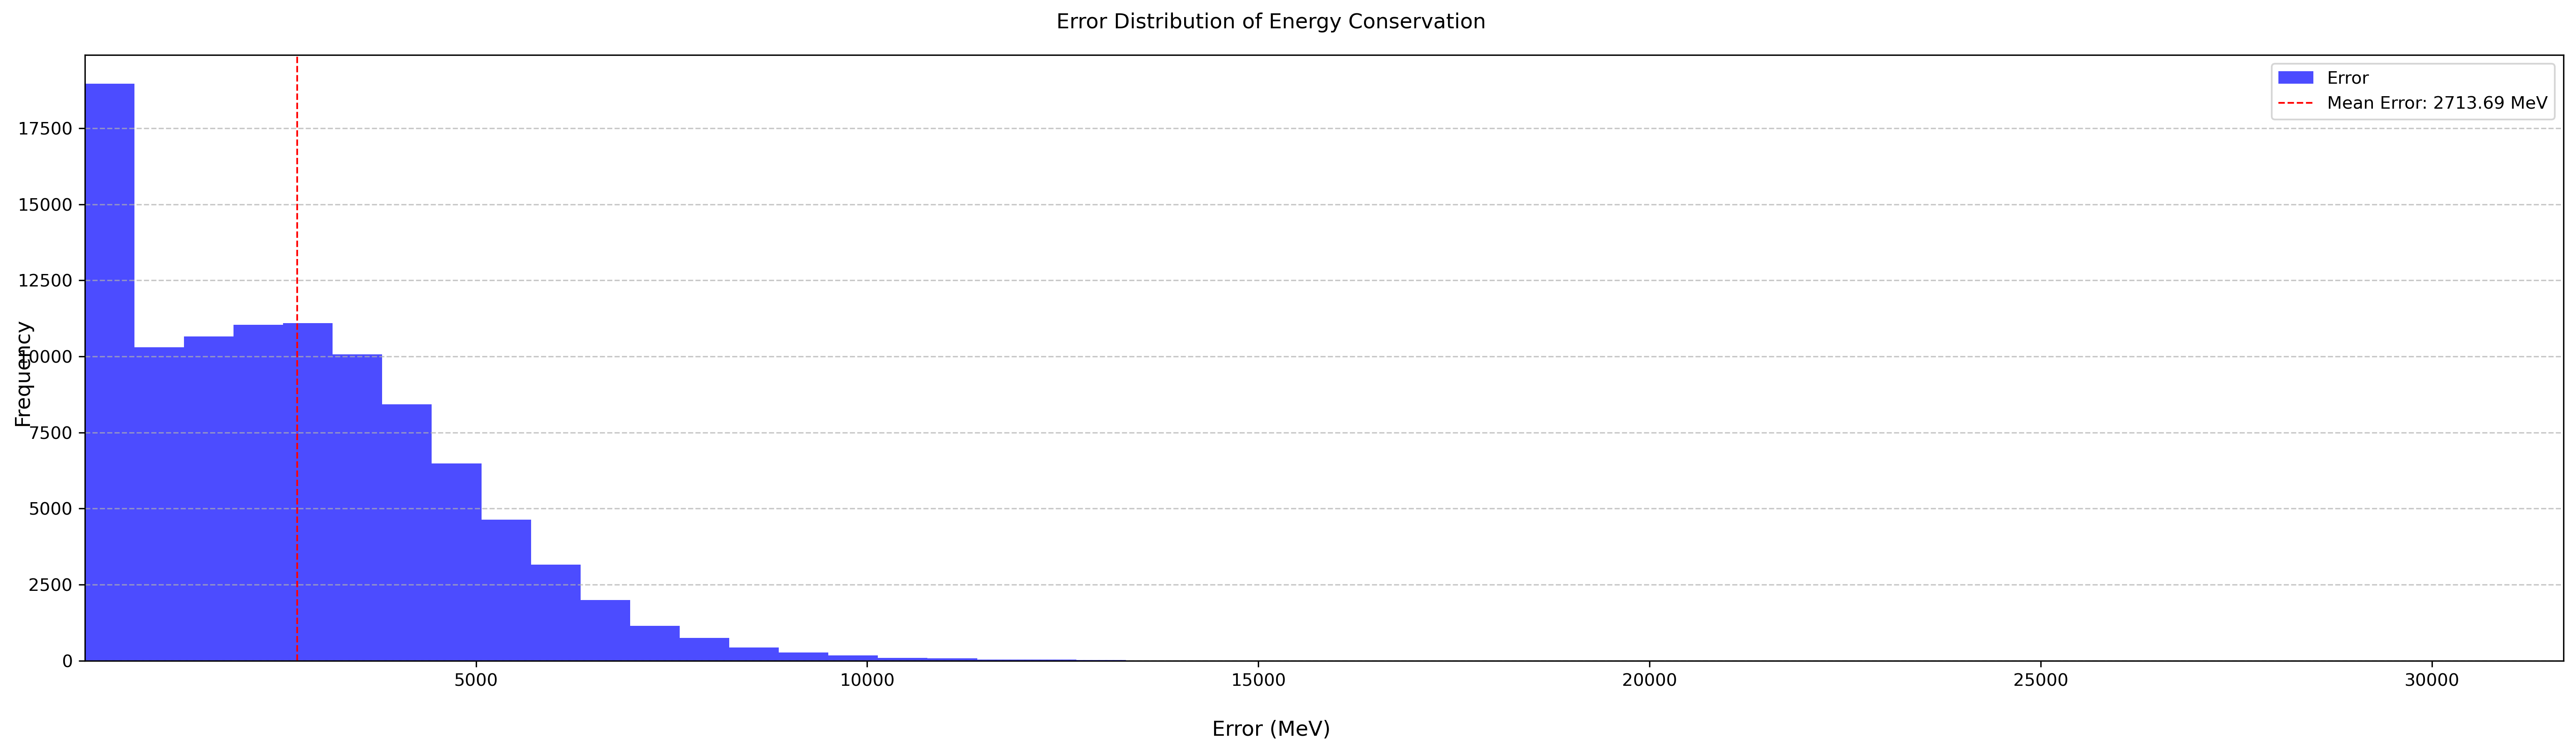

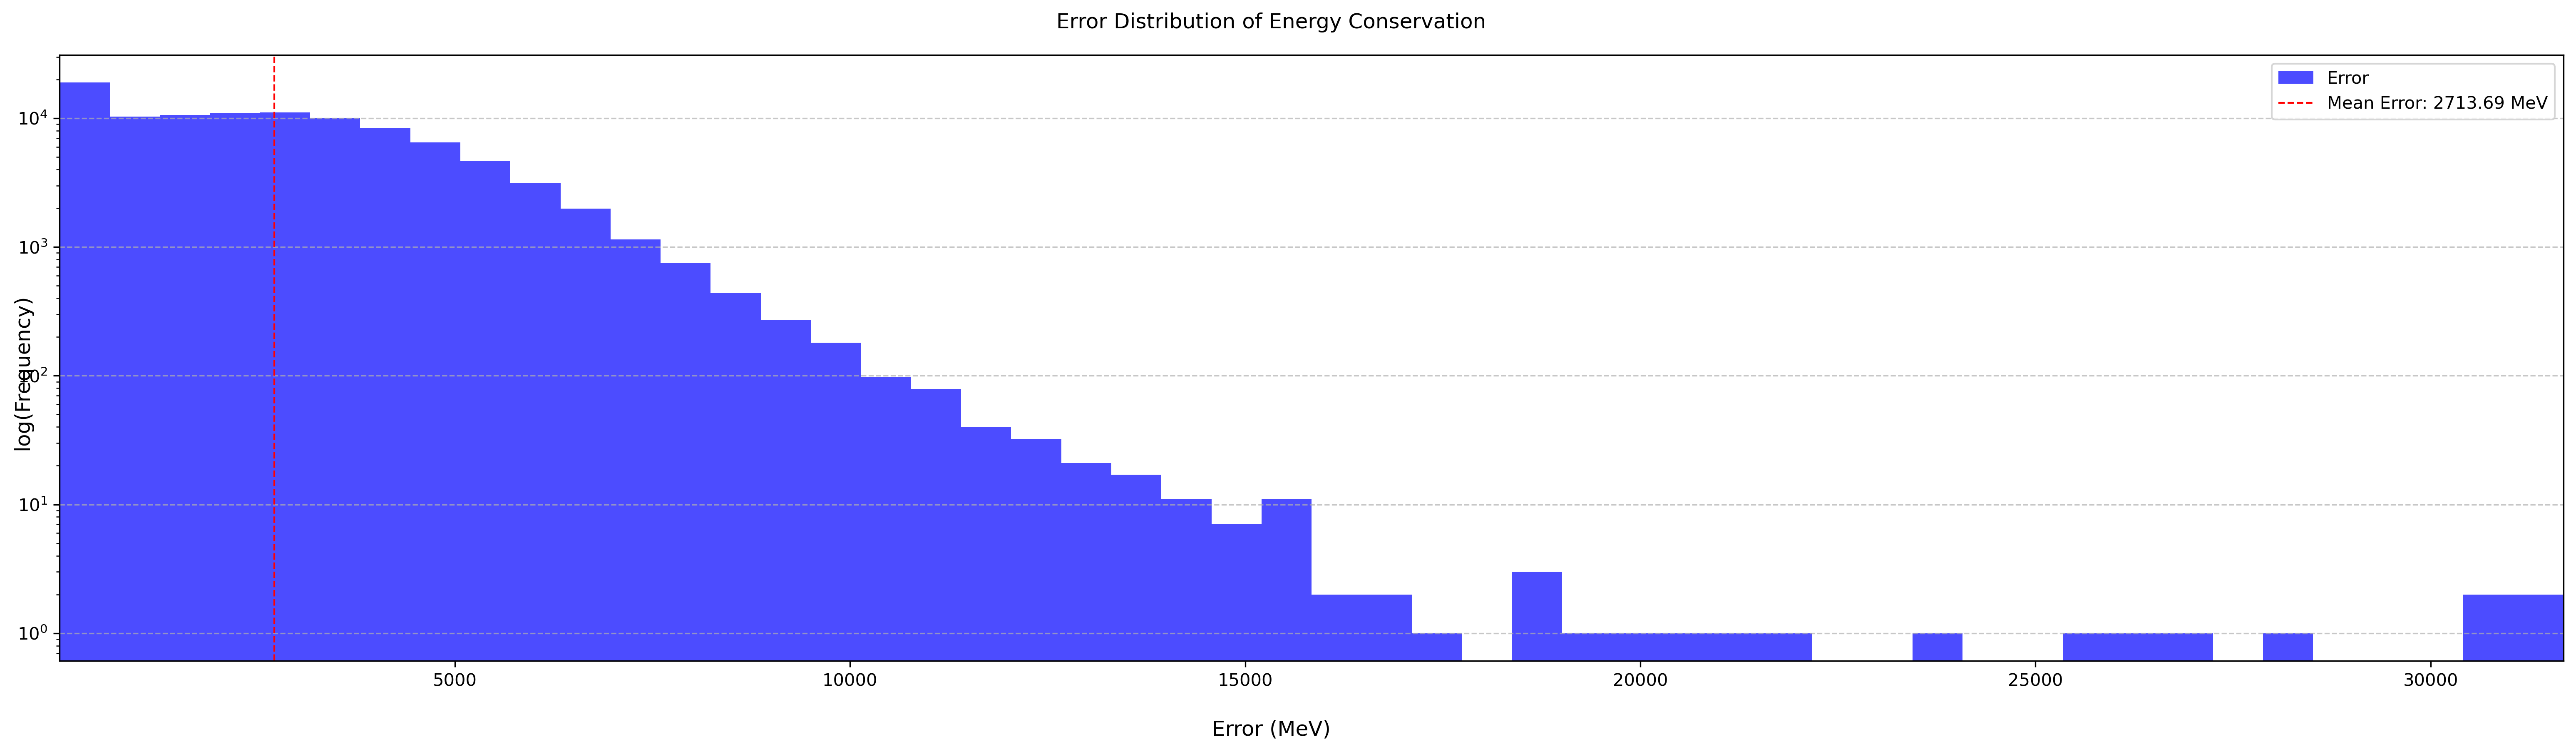

In [3]:
# Energy error stats
computed_err = np.abs(computed_data[:, 0] - computed_data[:, 1])
computed_err_mean = np.mean(computed_err)
err_range = np.max(computed_err) - np.min(computed_err)
print('min:', np.min(computed_err), 'max:', np.max(computed_err), 'range:', err_range, 'mean:', computed_err_mean)

# Plotting the error distribution
fig, ax = plt.subplots(figsize=anal.plotting.default_figsize, dpi=anal.plotting.default_dpi)
fig.suptitle('Error Distribution of Energy Conservation')
anal.plotting.set_labels('Error (MeV)', 'Frequency', in_fig=fig)
anal.plotting.plot_hist(computed_err, n_bins=50, label='Error', in_ax=ax)
ax.axvline(computed_err_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean Error: {computed_err_mean:.2f} MeV')
ax.legend()
fig.tight_layout()
fig.show()

# Plotting the error distribution log
fig, ax = plt.subplots(figsize=anal.plotting.default_figsize, dpi=anal.plotting.default_dpi)
fig.suptitle('Error Distribution of Energy Conservation')
anal.plotting.set_labels('Error (MeV)', 'log(Frequency)', in_fig=fig)
anal.plotting.plot_hist(computed_err, n_bins=50, label='Error', use_log=True, in_ax=ax)
ax.axvline(computed_err_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean Error: {computed_err_mean:.2f} MeV')
ax.legend()
fig.tight_layout()
fig.show()

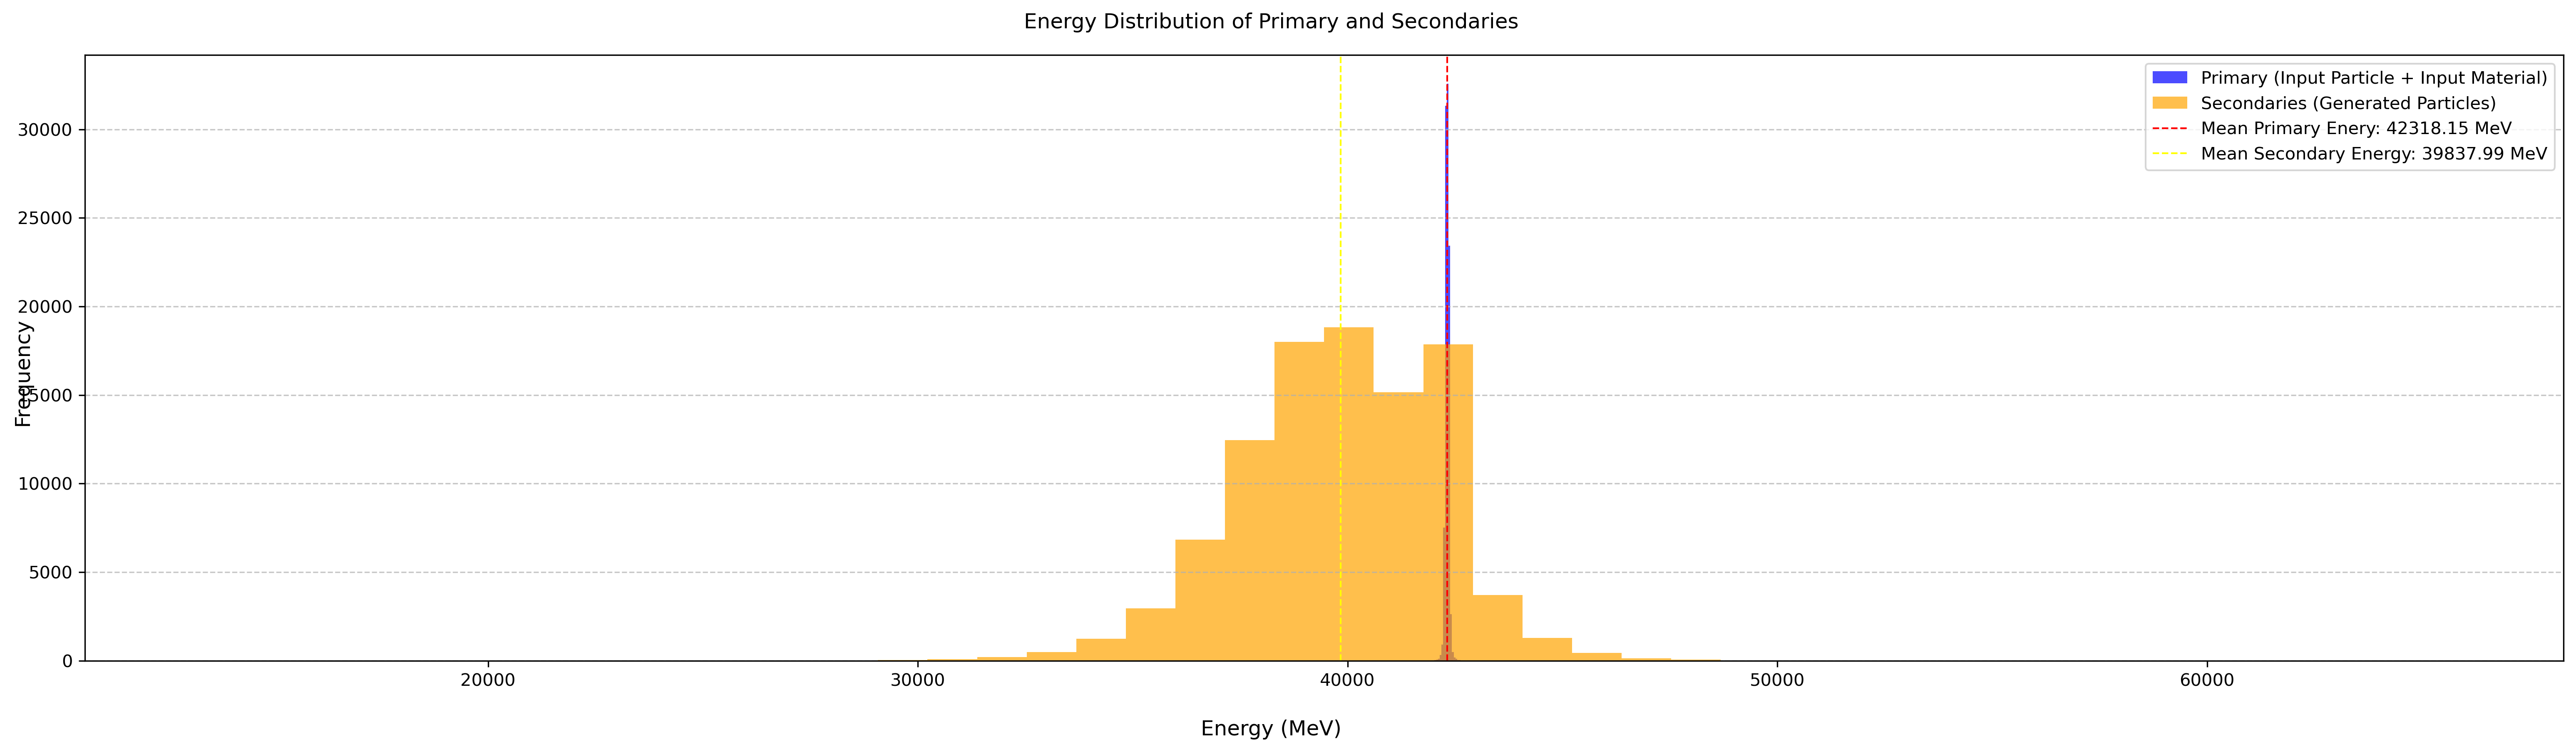

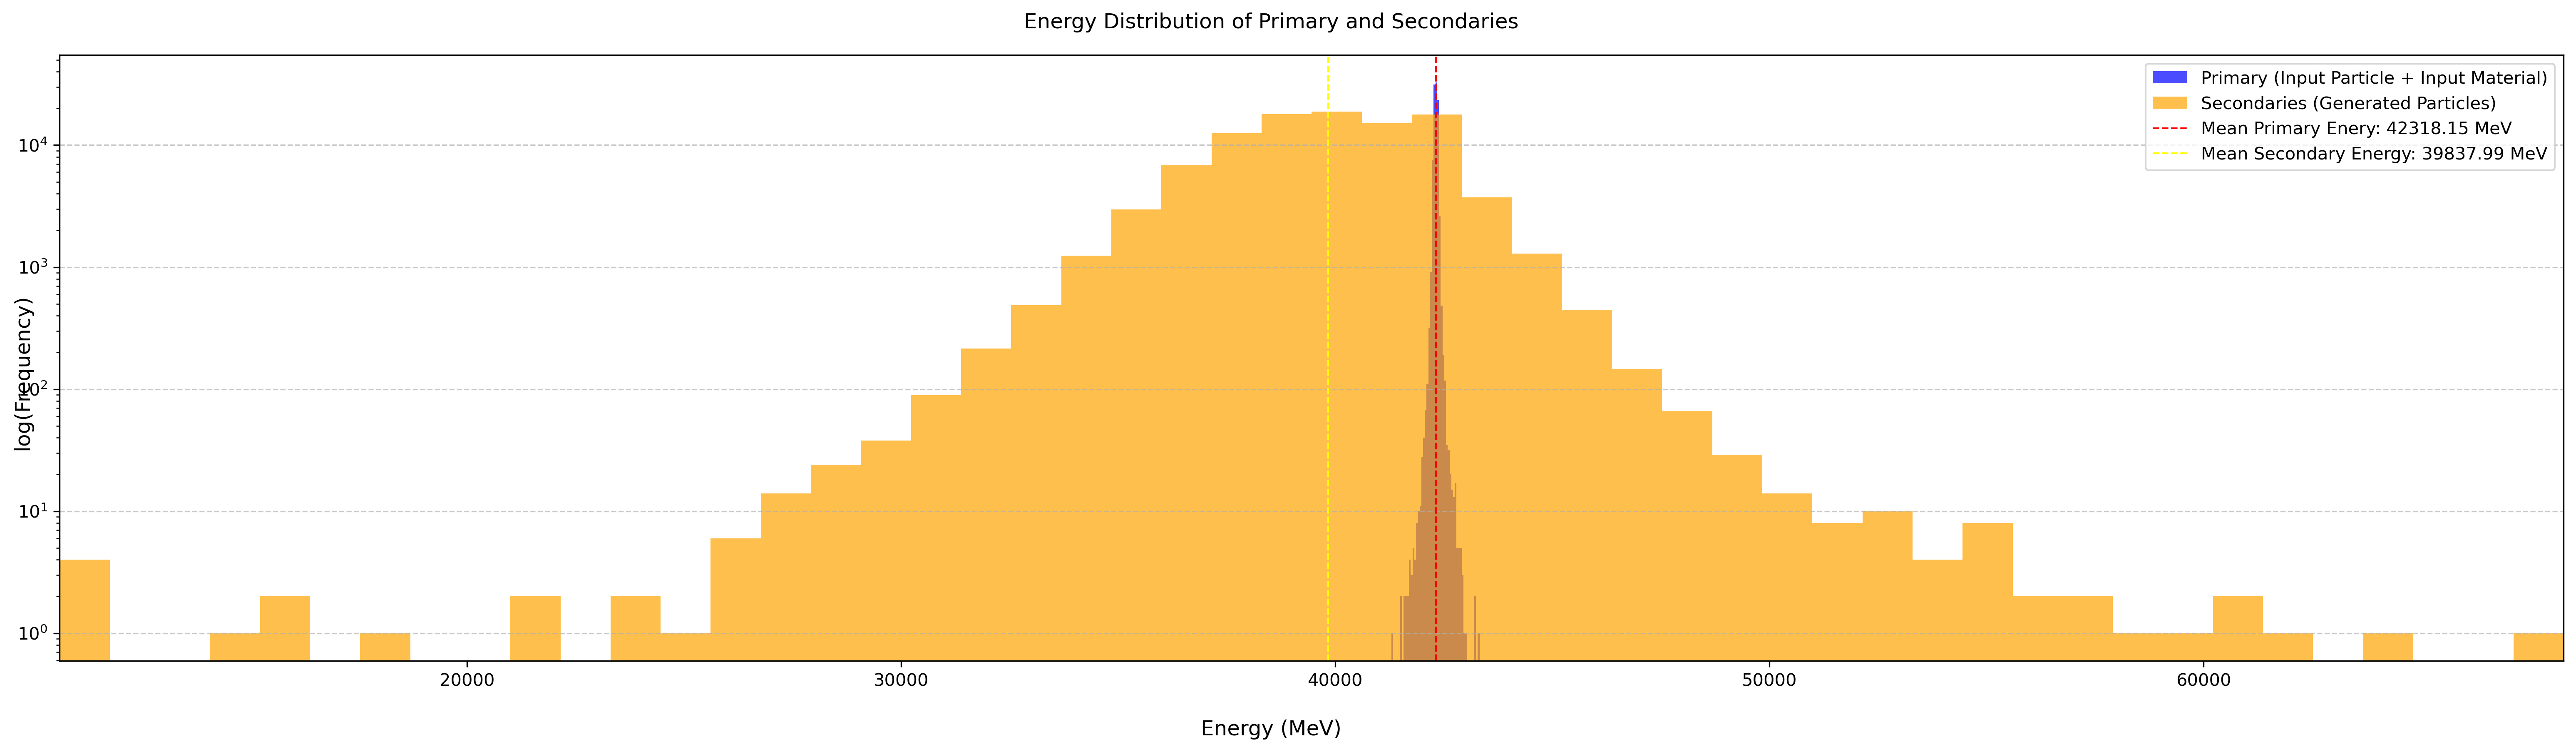

In [4]:
# Plotting energy distribution of primary and secondaries
fig, ax = plt.subplots(figsize=anal.plotting.default_figsize, dpi=anal.plotting.default_dpi)
fig.suptitle('Energy Distribution of Primary and Secondaries')
anal.plotting.set_labels('Energy (MeV)', 'Frequency', in_fig=fig)
anal.plotting.plot_hist(computed_data[:,0], n_bins=50, label='Primary (Input Particle + Input Material)', color=anal.plotting.colors[0], in_ax=ax)
anal.plotting.plot_hist(computed_data[:,1], n_bins=50, label='Secondaries (Generated Particles)', color=anal.plotting.colors[1], in_ax=ax)
ax.axvline(np.mean(computed_data[:,0]), color='red', linestyle='dashed', linewidth=1, label=f'Mean Primary Enery: {np.mean(computed_data[:,0]):.2f} MeV')
ax.axvline(np.mean(computed_data[:,1]), color='yellow', linestyle='dashed', linewidth=1, label=f'Mean Secondary Energy: {np.mean(computed_data[:,1]):.2f} MeV')
ax.legend()
fig.tight_layout()
fig.show()

# Plotting energy distribution of primary and secondaries log
fig, ax = plt.subplots(figsize=anal.plotting.default_figsize, dpi=anal.plotting.default_dpi)
fig.suptitle('Energy Distribution of Primary and Secondaries')
anal.plotting.set_labels('Energy (MeV)', 'log(Frequency)', in_fig=fig)
anal.plotting.plot_hist(computed_data[:,0], n_bins=50, label='Primary (Input Particle + Input Material)', color=anal.plotting.colors[0], use_log=True, in_ax=ax)
anal.plotting.plot_hist(computed_data[:,1], n_bins=50, label='Secondaries (Generated Particles)', color=anal.plotting.colors[1], use_log=True, in_ax=ax)
ax.axvline(np.mean(computed_data[:,0]), color='red', linestyle='dashed', linewidth=1, label=f'Mean Primary Enery: {np.mean(computed_data[:,0]):.2f} MeV')
ax.axvline(np.mean(computed_data[:,1]), color='yellow', linestyle='dashed', linewidth=1, label=f'Mean Secondary Energy: {np.mean(computed_data[:,1]):.2f} MeV')
ax.legend()
fig.tight_layout()
fig.show()